In [1]:
import numpy as np
import matplotlib.pyplot as plt

import qutip
sys.path.append("../utils")

plt.style.use("../matplotlib_style/standard_plot_style.mplstyle")

In [2]:
from matplotlib.colors import LinearSegmentedColormap
cmap_0 = LinearSegmentedColormap.from_list("mycmap", ["white", "C0"])
cmap_1 = LinearSegmentedColormap.from_list("mycmap", ["white", "C1"])
cmap_2 = LinearSegmentedColormap.from_list("mycmap", ["white", "C2"])

# Parameters

In [3]:
# Fitting parameters to hit! 
# Setup the qubit decay. We will fit these parameters later! 
rate_qubit_decay  = 1 / 250
rate_qubit_excite = 1 / 500
rate_reso_decay   = 1 / 500



# Simulation setup
simulation_steps = 2001
resonator_states        = 20
n_cutoff    = 15


# Setup Qubit, Resonator and Coupling
EJ          = 15     * 2 * np.pi # h GHz
EC          = EJ / 25
resonator_frequency     = 6.02 * 2 * np.pi    
coupling_strength       = 0.250 * 2 * np.pi


# Setup drive
drive_amplitude        = 0.020
driving_time           = (0, 150)


# Define Qubit object
import components as comp
qubit = comp.Transmon(
    EC = EC,
    EJ = EJ,
    basis = "charge",
    n_cutoff = n_cutoff
)
# Define resonator operators
from qutip import destroy
a       = destroy(resonator_states)
a_dag   = a.dag()

qubit_states = 3

# Get Qubit operators for the two level qubit
H_qubit, jump_matrix = qubit.lowest_k_eigenstates(k = qubit_states)

In [4]:
# Calculate all types of constants, which is useful for further analysis:
omega_01 = H_qubit.diag()[1] - H_qubit.diag()[0]
omega_02 = H_qubit.diag()[2] - H_qubit.diag()[0]
omega_12 = H_qubit.diag()[2] - H_qubit.diag()[1]

# Calculate the dispersive shifts
# Multi qubit shifts
g_squared_matrix = coupling_strength ** 2 * abs(jump_matrix.full()) ** 2
omega_ij_matrix = np.expand_dims(H_qubit.diag(), 1) - np.expand_dims(H_qubit.diag(), 0)
omega_r = resonator_frequency

# The Chi-matrix
chi_matrix = g_squared_matrix * (1 / (omega_ij_matrix - omega_r) + 1 / (omega_ij_matrix + omega_r)) 

# The dis
dispersive_shifts = chi_matrix.sum(axis = 1) / 2 / np.pi


# Omega resonator for qubits
omega_resonator_qubit = resonator_frequency + dispersive_shifts

# Information to print:
printing_dict = {
    "omega_01" : f"{omega_01 / 2 / np.pi:.3f} GHz",
    "omega_12" : f"{omega_12 / 2 / np.pi:.3f} GHz",
    "omega_02" : f"{omega_02 / 2 / np.pi:.3f} GHz",
    "omega_r"  : f"{resonator_frequency / 2 / np.pi:.3f} GHz",
    "omega_r_tilde": f"{np.mean(omega_resonator_qubit[:2]) / 2 / np.pi:.3f} GHz",
    "coupling_strength": f"{coupling_strength / 2 / np.pi:.3f} GHz",
    "dispersive_shift": f"{(dispersive_shifts[0] - dispersive_shifts[1]) * 1000 / 2 / 2 / np.pi:.3f} MHz",
    "drive_amplitude": f"{drive_amplitude * 1000:.3f} MHz",
    "driving_time": f"{driving_time[1]} ns",
    "rate_qubit_decay": f"{rate_qubit_decay * 1000:.3f} MHz",
    "rate_qubit_excite": f"{rate_qubit_excite * 1000:.3f} MHz",
    "rate_reso_decay": f"{rate_reso_decay * 1000:.3f} MHz",
}

printing_dict_symbolic = {
    r"\omega_{01}" : f"{omega_01 / 2 / np.pi:.3f} GHz",
    r"\omega_{12}" : f"{omega_12 / 2 / np.pi:.3f} GHz",
    r"\omega_{02}" : f"{omega_02 / 2 / np.pi:.3f} GHz",
    r"\omega_r"  : f"{resonator_frequency / 2 / np.pi:.3f} GHz",
    r"\tilde{\omega_r}": f"{np.mean(omega_resonator_qubit[:2]) / 2 / np.pi:.3f} GHz",
    r"g" : f"{coupling_strength / 2 / np.pi:.3f} GHz",
    r"\chi" : f"{(dispersive_shifts[0] - dispersive_shifts[1]) * 1000 / 2 / 2 / np.pi:.3f} MHz",
    r"A" : f"{drive_amplitude * 1000:.3f} MHz",
    r"T" : f"{driving_time[1]} ns",
    r"\Gamma_q" : f"{rate_qubit_decay * 1000:.3f} MHz",
    r"\Gamma_e" : f"{rate_qubit_excite * 1000:.3f} MHz",
    r"\Gamma_r" : f"{rate_reso_decay * 1000:.3f} MHz",
}

variable_dict = {
    "omega_01" : omega_01,
    "omega_12" : omega_12,
    "omega_02" : omega_02,
    "omega_r"  : resonator_frequency,
    "omega_r_tilde": np.mean(omega_resonator_qubit[:2]),
    "coupling_strength": coupling_strength,
    "dispersive_shift": (dispersive_shifts[0] - dispersive_shifts[1]),
}

for key, value in printing_dict.items():
    print(f"{key} \t= {value}")


omega_01 	= 7.834 GHz
omega_12 	= 7.050 GHz
omega_02 	= 14.884 GHz
omega_r 	= 6.020 GHz
omega_r_tilde 	= 6.012 GHz
coupling_strength 	= 0.250 GHz
dispersive_shift 	= 2.600 MHz
drive_amplitude 	= 20.000 MHz
driving_time 	= 150 ns
rate_qubit_decay 	= 4.000 MHz
rate_qubit_excite 	= 2.000 MHz
rate_reso_decay 	= 2.000 MHz


## Setup functions to use

In [5]:
from qutip import tensor, basis, ket2dm
from tqdm import tqdm

# We can now define the Hamiltonian:
def get_Hamiltonian(drive_frequency):
    H_res   = (omega_r - drive_frequency) * tensor(qutip.qeye(qubit_states), a_dag * a)

    H_disp  = tensor(qutip.Qobj(np.diag(dispersive_shifts)), a_dag * a)

    H_drive = drive_amplitude * tensor(qutip.qeye(qubit_states), a_dag + a)

    return H_res + H_disp + H_drive


from scipy.special import factorial 
def Q_of_rho(rho, x, y):
    rho = rho.full()
    n_cutoff = rho.shape[0]

    alphas = x + 1j * y
    # alphas *= 1 / np.sqrt(2)

    normalization = np.exp(- alphas * alphas.conj() / 2)

    # Basis change
    ns = np.expand_dims(np.arange(n_cutoff), 1)
    P  = normalization * np.power(alphas, ns) / np.sqrt(factorial(ns))

    Q_output = 1 / np.pi * np.einsum("ij, jk, ki -> i", P.T.conj(), rho, P)
    return Q_output.real

In [6]:
drive_frequency = omega_resonator_qubit[0] / 2 + omega_resonator_qubit[1]  / 2
Hamiltonian = get_Hamiltonian(drive_frequency)

initial_0 = ket2dm(tensor(basis(qubit_states, 0), basis(resonator_states, 0)))
initial_1 = ket2dm(tensor(basis(qubit_states, 1), basis(resonator_states, 0)))

# We can now define the collapse operators
qubit_decay_matrix = np.zeros((qubit_states, qubit_states))
qubit_decay_matrix[0, 1] = 1

qubit_decay_operator = tensor(qutip.Qobj(qubit_decay_matrix), qutip.qeye(resonator_states))
qubit_excite_operator = tensor(qutip.Qobj(qubit_decay_matrix.T), qutip.qeye(resonator_states))

# Setup the resonator decay
reso_decay_operator = np.sqrt(rate_reso_decay) * tensor(qutip.qeye(qubit_states), a)


from qutip import mesolve, Options

def simulated_density_matrix(params, initial_state = initial_0):
    # The parameters which are used to fit
    qubit_decay         = params[0]
    qubit_excitation    = params[1]
    resonator_decay     = params[2]

    decays = [np.sqrt(qubit_decay) * qubit_decay_operator, 
              np.sqrt(qubit_excitation) * qubit_excite_operator, 
              np.sqrt(resonator_decay) * reso_decay_operator]

    # Run simulation
    result = mesolve(
        Hamiltonian,
        initial_state,
        np.linspace(*driving_time, simulation_steps),
        c_ops = decays,
        options = Options(store_states = True, store_final_state = True),
    )

    return result




# Generate Sampled Data

In [7]:
from scipy.optimize import minimize
def hit_n_miss(rho, n_samples = 100, n_tries = 10000, lims = (-5, 5)):
    # We set up the bounds and find the max value
    xlim = ylim = lims

    minimize_result = minimize(lambda x: - Q_of_rho(rho, x[0], x[1]), [0, 0])
    max_bound = - 1.05 * minimize_result.fun

    # Now we can generate hit-miss samples
    x_sample = np.random.uniform(*xlim, n_tries)
    y_sample = np.random.uniform(*ylim, n_tries)
    p_sample = np.random.uniform(0, max_bound, n_tries)

    # Generate true vals of x and y
    p_calculated = Q_of_rho(rho, x_sample, y_sample)

    # Mask from the hit-n-miss
    mask = p_sample < p_calculated

    print(f"Got {np.sum(mask)} hits out of {n_samples} samples")
    return (x_sample[mask][:n_samples], y_sample[mask][:n_samples])

In [8]:
xvec = yvec = np.linspace(-5, 5, 100)

from qutip import QFunc
qfunc = QFunc(xvec, yvec)

Got 399 hits out of 100 samples
Got 524 hits out of 100 samples


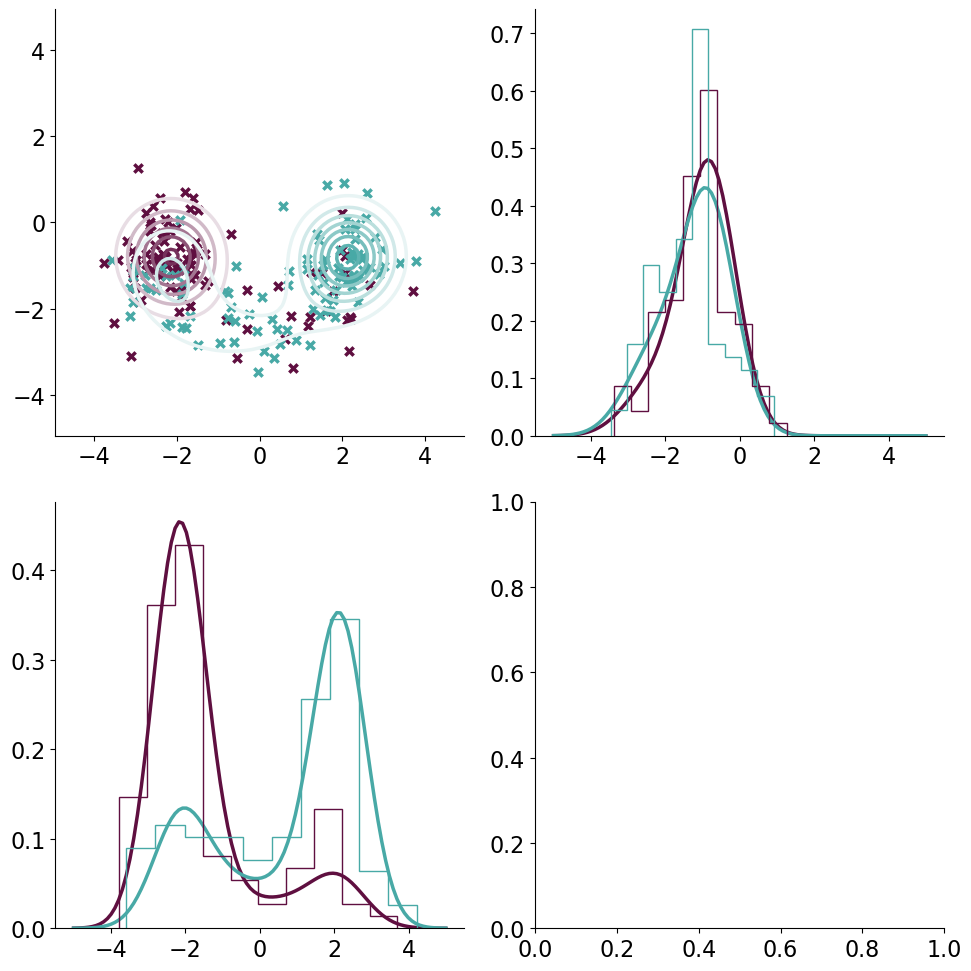

In [9]:
fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = (10, 10))
ax = ax.flatten()

final_state_0 = simulated_density_matrix([rate_qubit_decay, rate_qubit_excite, rate_reso_decay], initial_0).final_state.ptrace(1)
final_state_1 = simulated_density_matrix([rate_qubit_decay, rate_qubit_excite, rate_reso_decay], initial_1).final_state.ptrace(1)

xvec = yvec = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(xvec, yvec)
area = (xvec[1] - xvec[0]) * (yvec[1] - yvec[0])

Q_0 = Q_of_rho(final_state_0, X.flatten(), Y.flatten()).reshape(X.shape)
Q_1 = Q_of_rho(final_state_1, X.flatten(), Y.flatten()).reshape(X.shape)

ax[0].contour(Q_0, origin = "lower", cmap = cmap_0, extent = [xvec[0], xvec[-1], yvec[0], yvec[-1]])
ax[0].contour(Q_1, origin = "lower", cmap = cmap_1, extent = [xvec[0], xvec[-1], yvec[0], yvec[-1]])

state_0_sample = hit_n_miss(final_state_0)
ax[0].scatter(state_0_sample[0], state_0_sample[1], marker = "x", color = "C0")

state_1_sample = hit_n_miss(final_state_1)
ax[0].scatter(state_1_sample[0], state_1_sample[1], marker = "x", color = "C1")

ax[2].plot(xvec, np.sqrt(area) * Q_0.sum(axis = 0))
ax[2].plot(xvec, np.sqrt(area) * Q_1.sum(axis = 0))

ax[2].hist(state_0_sample[0], bins = 10, density = True, color = "C0", histtype = "step")
ax[2].hist(state_1_sample[0], bins = 10, density = True, color = "C1", histtype = "step")

ax[1].plot(yvec, np.sqrt(area) * Q_0.sum(axis = 1))
ax[1].plot(yvec, np.sqrt(area) * Q_1.sum(axis = 1))

ax[1].hist(state_0_sample[1], bins = 10, density = True, color = "C0", histtype = "step")
ax[1].hist(state_1_sample[1], bins = 10, density = True, color = "C1", histtype = "step")



fig.tight_layout()


# Fit Simulation to Data

In [29]:
def compute_nllh(xs, ys, params, initial_state = 0):
    initial_state = [initial_0, initial_1][initial_state]
    rho = simulated_density_matrix(params, initial_state).final_state.ptrace(1)

    Q = Q_of_rho(rho, xs, ys)

    return - np.sum(np.log(Q))

In [30]:
scan_qubit_decay_rate   = np.power(10, np.linspace(-5, -1, 30))
scan_qubit_excite_rate  = np.power(10, np.linspace(-5, -1, 30))

xs_0, ys_0 = state_0_sample[0], state_0_sample[1]
xs_1, ys_1 = state_1_sample[0], state_1_sample[1]

nllh_0_decay = np.zeros_like(scan_qubit_decay_rate)
nllh_1_decay = np.zeros_like(scan_qubit_decay_rate)

print("Scanning decay rates")
for i in tqdm(range(scan_qubit_decay_rate.shape[0])):
    nllh_0_decay[i] = compute_nllh(xs_0, ys_0, [scan_qubit_decay_rate[i], rate_qubit_excite, rate_reso_decay], 0)
    nllh_1_decay[i] = compute_nllh(xs_1, ys_1, [scan_qubit_decay_rate[i], rate_qubit_excite, rate_reso_decay], 1)

nllh_0_excite = np.zeros_like(scan_qubit_excite_rate)
nllh_1_excite = np.zeros_like(scan_qubit_excite_rate)

print("Scanning excitation rates")
for i in tqdm(range(scan_qubit_excite_rate.shape[0])):
    nllh_0_excite[i] = compute_nllh(xs_0, ys_0, [rate_qubit_decay, scan_qubit_excite_rate[i], rate_reso_decay], 0)
    nllh_1_excite[i] = compute_nllh(xs_1, ys_1, [rate_qubit_decay, scan_qubit_excite_rate[i], rate_reso_decay], 1)




Scanning decay rates


100%|██████████| 30/30 [00:08<00:00,  3.64it/s]


Scanning excitation rates


100%|██████████| 30/30 [00:08<00:00,  3.65it/s]


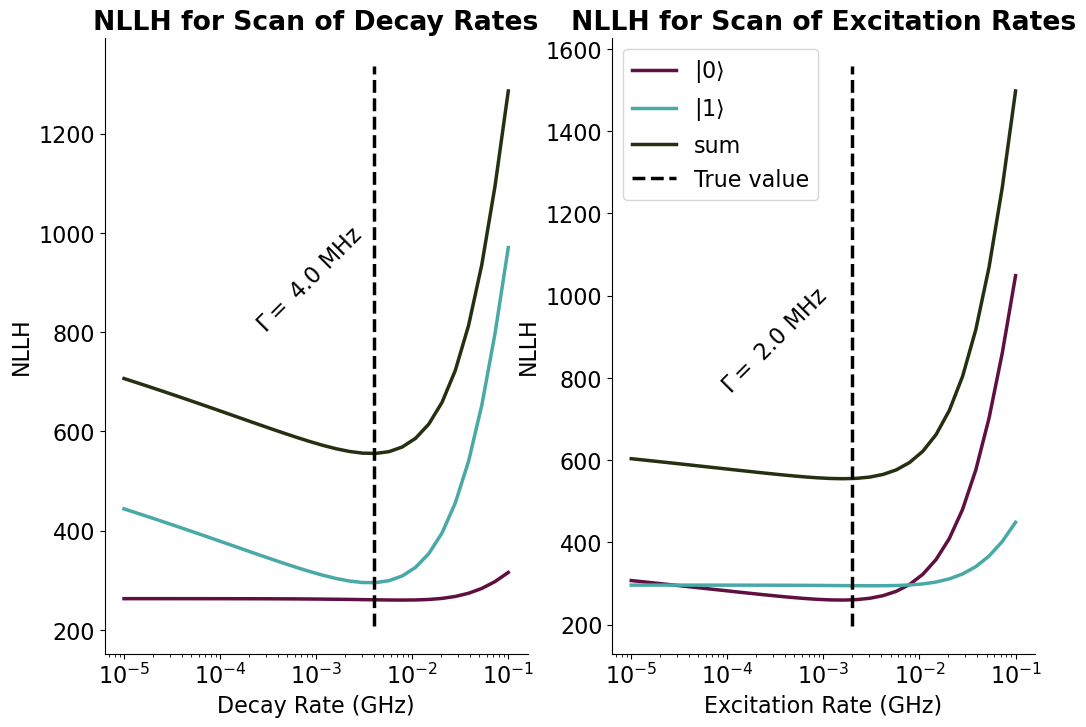

In [31]:
fig, ax = plt.subplots(ncols = 2)

ax[0].plot(scan_qubit_decay_rate, nllh_0_decay, label = r"$|0\rangle$")
ax[0].plot(scan_qubit_decay_rate, nllh_1_decay, label = r"$|1\rangle$")
ax[0].plot(scan_qubit_decay_rate, nllh_0_decay +nllh_1_decay , label = "sum")
ax[0].set_xscale("log")
ax[0].vlines(rate_qubit_decay, *ax[0].get_ylim(), color = "k", linestyle = "--", label = "True value")

ax[0].set(
    title = "NLLH for Scan of Decay Rates",
    xlabel = "Decay Rate (GHz)",
    ylabel = "NLLH",
)

ax[0].text(0.35, 0.70, f"$\Gamma = $ {1000 * rate_qubit_decay:.1f} MHz", rotation = 45, transform = ax[0].transAxes, va = "top", ha = "left")

ax[1].plot(scan_qubit_excite_rate, nllh_0_excite, label = r"$|0\rangle$")
ax[1].plot(scan_qubit_excite_rate, nllh_1_excite, label = r"$|1\rangle$")
ax[1].plot(scan_qubit_excite_rate, nllh_0_excite + nllh_1_excite , label = "sum")
ax[1].set_xscale("log")
ax[1].vlines(rate_qubit_excite, *ax[1].get_ylim(), color = "k", linestyle = "--", label = "True value")

ax[1].set(
    title = "NLLH for Scan of Excitation Rates",
    xlabel = "Excitation Rate (GHz)",
    ylabel = "NLLH",
)

ax[1].text(0.25, 0.60, f"$\Gamma = $ {1000 * rate_qubit_excite:.1f} MHz", rotation = 45, transform = ax[1].transAxes, va = "top", ha = "left")


ax[1].legend()

In [32]:
minimum_for_decay = scan_qubit_decay_rate[np.argmin(nllh_0_decay + nllh_1_decay)]
minimum_for_excite = scan_qubit_excite_rate[np.argmin(nllh_0_excite + nllh_1_excite)]

Scanning decay rates


100%|██████████| 30/30 [00:08<00:00,  3.60it/s]


Scanning excitation rates


100%|██████████| 30/30 [00:08<00:00,  3.55it/s]


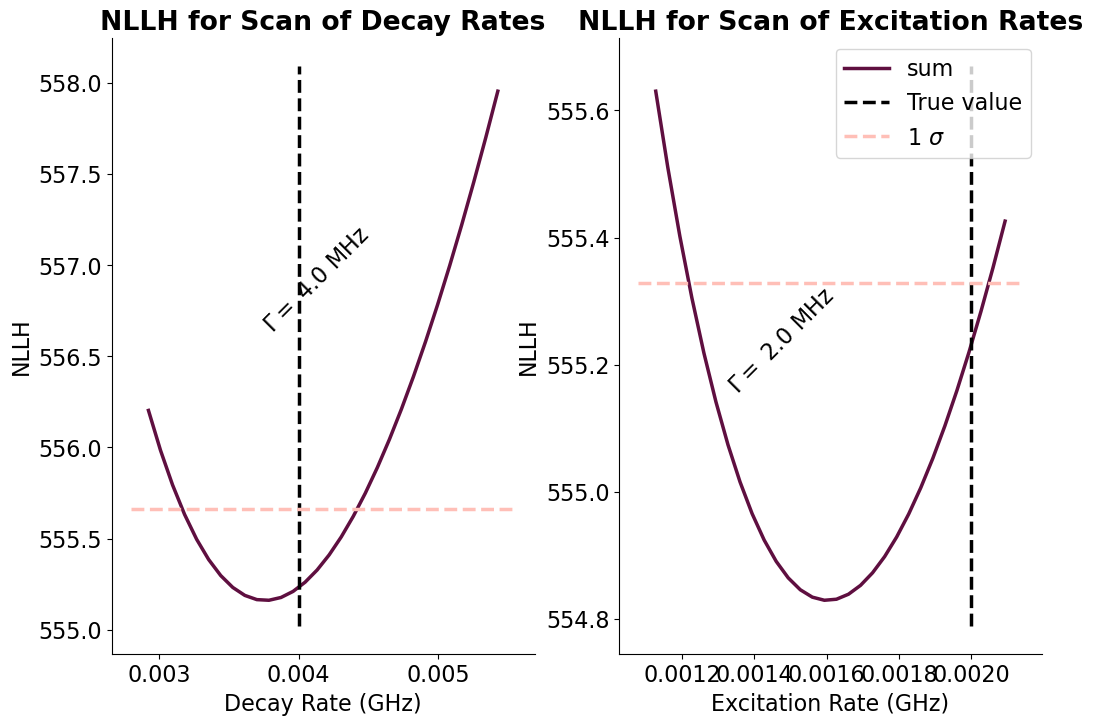

In [34]:
scan_qubit_decay_rate   = np.linspace(minimum_for_decay * 0.7, minimum_for_decay * 1.3, 30)
scan_qubit_excite_rate  = np.linspace(minimum_for_excite * 0.7, minimum_for_excite * 1.3, 30)

xs_0, ys_0 = state_0_sample[0], state_0_sample[1]
xs_1, ys_1 = state_1_sample[0], state_1_sample[1]

nllh_0_decay = np.zeros_like(scan_qubit_decay_rate)
nllh_1_decay = np.zeros_like(scan_qubit_decay_rate)

print("Scanning decay rates")
for i in tqdm(range(scan_qubit_decay_rate.shape[0])):
    nllh_0_decay[i] = compute_nllh(xs_0, ys_0, [scan_qubit_decay_rate[i], rate_qubit_excite, rate_reso_decay], 0)
    nllh_1_decay[i] = compute_nllh(xs_1, ys_1, [scan_qubit_decay_rate[i], rate_qubit_excite, rate_reso_decay], 1)

nllh_0_excite = np.zeros_like(scan_qubit_excite_rate)
nllh_1_excite = np.zeros_like(scan_qubit_excite_rate)

print("Scanning excitation rates")
for i in tqdm(range(scan_qubit_excite_rate.shape[0])):
    nllh_0_excite[i] = compute_nllh(xs_0, ys_0, [rate_qubit_decay, scan_qubit_excite_rate[i], rate_reso_decay], 0)
    nllh_1_excite[i] = compute_nllh(xs_1, ys_1, [rate_qubit_decay, scan_qubit_excite_rate[i], rate_reso_decay], 1)


fig, ax = plt.subplots(ncols = 2)

# ax[0].plot(scan_qubit_decay_rate, nllh_0_decay, label = r"$|0\rangle$")
# ax[0].plot(scan_qubit_decay_rate, nllh_1_decay, label = r"$|1\rangle$")
ax[0].plot(scan_qubit_decay_rate, nllh_0_decay +nllh_1_decay , label = "sum")
# ax[0].set_xscale("log")
ax[0].vlines(rate_qubit_decay, *ax[0].get_ylim(), color = "k", linestyle = "--", label = "True value")
ax[0].hlines(np.min(nllh_0_decay + nllh_1_decay) + 1 / 2, *ax[0].get_xlim(), color = "C5", linestyle = "--", label = "1 $\sigma$")

ax[0].set(
    title = "NLLH for Scan of Decay Rates",
    xlabel = "Decay Rate (GHz)",
    ylabel = "NLLH",
)

# ax[0].text(0.35, 0.70, f"$\Gamma = $ {1000 * rate_qubit_decay:.1f} MHz", rotation = 45, transform = ax[0].transAxes, va = "top", ha = "left")

# ax[1].plot(scan_qubit_excite_rate, nllh_0_excite, label = r"$|0\rangle$")
# ax[1].plot(scan_qubit_excite_rate, nllh_1_excite, label = r"$|1\rangle$")
ax[1].plot(scan_qubit_excite_rate, nllh_0_excite + nllh_1_excite , label = "sum")
# ax[1].set_xscale("log")
ax[1].vlines(rate_qubit_excite, *ax[1].get_ylim(), color = "k", linestyle = "--", label = "True value")
ax[1].hlines(np.min(nllh_0_excite + nllh_1_excite) + 1 / 2, *ax[1].get_xlim(), color = "C5", linestyle = "--", label = "1 $\sigma$")

ax[1].set(
    title = "NLLH for Scan of Excitation Rates",
    xlabel = "Excitation Rate (GHz)",
    ylabel = "NLLH",
)

# ax[1].text(0.25, 0.60, f"$\Gamma = $ {1000 * rate_qubit_excite:.1f} MHz", rotation = 45, transform = ax[1].transAxes, va = "top", ha = "left")


ax[1].legend()

## 3D Plot

In [37]:
scan_qubit_decay_rate   = np.linspace(minimum_for_decay * 0.7, minimum_for_decay * 1.3, 30)
scan_qubit_excite_rate  = np.linspace(minimum_for_excite * 0.7, minimum_for_excite * 1.3, 30)

scan_x, scan_y = np.meshgrid(scan_qubit_decay_rate, scan_qubit_excite_rate)

nllh_0 = np.zeros_like(scan_x)
nllh_1 = np.zeros_like(scan_x)

for index, _ in tqdm(np.ndenumerate(nllh_0), total = nllh_0.size):
    nllh_0[index] = compute_nllh(xs_0, ys_0, [scan_x[index], scan_y[index], rate_reso_decay], 0)
    nllh_1[index] = compute_nllh(xs_1, ys_1, [scan_x[index], scan_y[index], rate_reso_decay], 1)


100%|██████████| 900/900 [04:10<00:00,  3.60it/s]


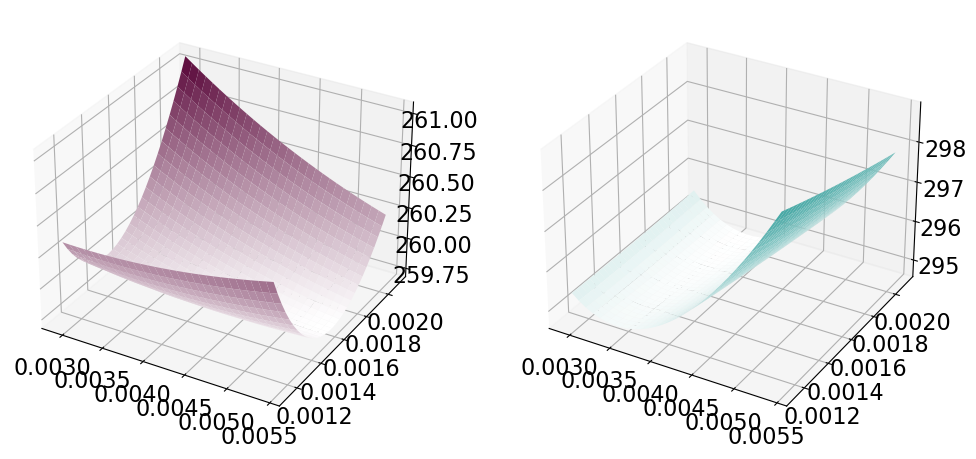

In [40]:
fig, ax = plt.subplots(ncols = 2, subplot_kw = {"projection" : "3d"})

ax[0].plot_surface(scan_x, scan_y, nllh_0, cmap = cmap_0)
ax[1].plot_surface(scan_x, scan_y, nllh_1, cmap = cmap_1)


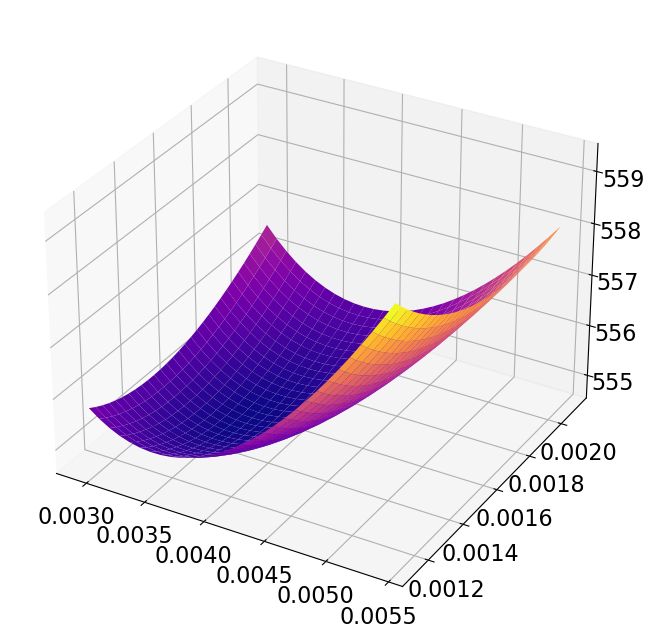

In [41]:
fig, ax = plt.subplots(subplot_kw = {"projection" : "3d"})

ax.plot_surface(scan_x, scan_y, nllh_0 + nllh_1, cmap = "plasma")

In [42]:
x_min = scan_x.flatten()[(nllh_0 + nllh_1).argmin()]
y_min = scan_y.flatten()[(nllh_0 + nllh_1).argmin()]

[Text(0.5, 1.0, 'NLLH for Scan of Decay and Excitation Rates'),
 Text(0.5, 0, 'Decay Rate (GHz)'),
 Text(0, 0.5, 'Excitation Rate (GHz)')]

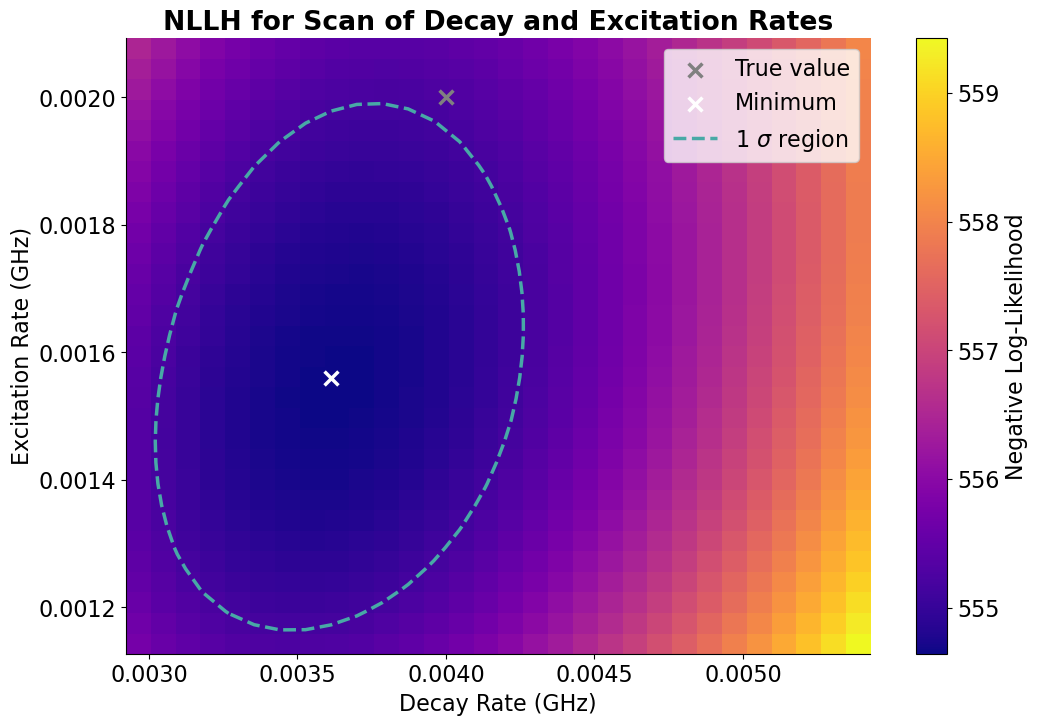

In [64]:
fig, ax = plt.subplots()

imshow = ax.imshow(nllh_0 + nllh_1, cmap = "plasma", origin = "lower", extent = [scan_x.min(), scan_x.max(), scan_y.min(), scan_y.max()], aspect = "auto")
plt.colorbar(imshow, ax = ax, label = "Negative Log-Likelihood")


ax.scatter(rate_qubit_decay, rate_qubit_excite, color = "gray", marker = "x", s = 100, label = "True value")
ax.scatter(x_min, y_min, color = "white", marker = "x", s = 100, label = "Minimum")

ax.contour(scan_x, scan_y, nllh_0 + nllh_1, levels = [np.min(nllh_0 + nllh_1) + 1 / 2], colors = "C1", linestyles = "--")
ax.plot(np.nan, np.nan, color = "C1", linestyle = "--", label = "1 $\sigma$ region")

ax.legend()

ax.set(
    title = "NLLH for Scan of Decay and Excitation Rates",
    xlabel = "Decay Rate (GHz)",
    ylabel = "Excitation Rate (GHz)",
)